# 사용자 맞춤 뉴스 추천 모델링

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_bosa = pd.read_csv("./csv/bosa_news.csv")

In [3]:
df_bosa.drop(columns=['_id'], inplace=True)
df_bosa.dropna(subset=['news_title'], inplace=True)
df_bosa.head()

,news_title,news_url,news_when,news_topic
0,"한국쿄와기린, 세계 희귀질환의 날 행사 참여",http://www.bosa.co.kr/news/articleView.html?id...,02.29 11:57,다국적제약/의료기기
1,"광동제약, ‘세계 희귀질환의 날’ 기념 환아 작품 전시회 개최",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:52,제약산업
2,"순천향대 부천병원 신영림 교수, ‘질병관리청장 표창’ 수상",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:29,동정
3,"창립 70주년 한독, ‘THANKS CAMPAIGN’ 실시",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:07,제약산업
4,[세계 희귀질환의 날] 국가‧사회‧이웃‧의료진‧가족 함께 가야 한다,http://www.bosa.co.kr/news/articleView.html?id...,02.29 05:50,학회/학술


In [4]:
df_bosa['news_topic'].value_counts()  #제약/개발 #병원 #법령/정책 #의료기기 #학회/학술 #

news_topic
제약산업          472
제약            360
기타기관          251
병원            212
병의원           206
복지부            95
기획연재           91
제약·유통          67
다국적제약/의료기기     62
국회             61
학회/학술          60
개원가            57
식약처            54
바이오            52
동정             47
의료             41
의료기기·IT        40
질병청            37
심평원            33
의약정책           19
건보공단           19
의료단체           16
약사단체           12
유통             10
식품              8
협회              8
진흥원             5
책소개             5
포토뉴스            4
인사              4
단신              3
정책·행정           3
의료기기            3
약사·약국           2
너몰내알            1
보사연             1
치과/한의사          1
의원·병원           1
화장품             1
약대/학술           1
Name: count, dtype: int64

In [5]:
df_bosa.info

<bound method DataFrame.info of                                  news_title  \
0                  한국쿄와기린, 세계 희귀질환의 날 행사 참여   
1        광동제약, ‘세계 희귀질환의 날’ 기념 환아 작품 전시회 개최   
2          순천향대 부천병원 신영림 교수, ‘질병관리청장 표창’ 수상   
3          창립 70주년 한독, ‘THANKS CAMPAIGN’ 실시   
4     [세계 희귀질환의 날] 국가‧사회‧이웃‧의료진‧가족 함께 가야 한다   
...                                     ...   
2421                     26일 `희귀질환 치료' 심포지엄   
2422                  `희귀^난치성질환자 연합회' 구성 추진   
2423                      책임운영기관 평가 “적정성 결여   
2424                    먹지도 굶지도 못하는 희귀질환 발견   
2425                희귀의약품센터 공익성 기부금 대상단체 지정   

                                               news_url         news_when  \
0     http://www.bosa.co.kr/news/articleView.html?id...       02.29 11:57   
1     http://www.bosa.co.kr/news/articleView.html?id...       02.29 10:52   
2     http://www.bosa.co.kr/news/articleView.html?id...       02.29 10:29   
3     http://www.bosa.co.kr/news/articleView.html?id...       02.29 10:07   
4     http://www.b

In [6]:
df_bosa.isnull().sum()

news_title    0
news_url      0
news_when     0
news_topic    0
dtype: int64

In [7]:
df_bosa = df_bosa.reset_index().drop(columns='index')

In [8]:
df_bosa_test1 = df_bosa.copy()

In [9]:
df_bosa_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2425 entries, 0 to 2424
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   news_title  2425 non-null   object
 1   news_url    2425 non-null   object
 2   news_when   2425 non-null   object
 3   news_topic  2425 non-null   object
dtypes: object(4)
memory usage: 75.9+ KB


## 1. 군집화 후 토픽 분류
- 우선 1차적으로 군집을 만들어 어떠한 topic으로 분류되는지 확인해보자

In [10]:
df_bosa_test1 = df_bosa.dropna(subset=['news_title'])

### 토큰화

In [3]:
# 불용어 리스트 생성 '녹십자'
stopwords = ['서울대', '희귀질환', '희귀', '대다',  '케다', '소아', '생명', '한국', '한미','사노피', '하다', '급여', '국내', '샤이어',  '스케', '세포'
            , '병원',  '질환',  '한독', '화이자제약',  '전달', '질병', '인하대병원',  '관리', '다국적', '환자', '지정', '치료'
            , '오다', '헌터', '작년', '브리', '위해', '베다', '받다', '심평원', '코로나', '건보', '화순', '전남대', '실시', '자임','녹십자'
            ] #추가 생성 필요
f=open('./csv/korean_stopwords_basic.txt') #기본적으로 제공되는 한국어 불용어 리스트 파일
lines = f.readlines()
for line in lines:
    line = line.strip()
    stopwords.append(line)
f.close()

In [4]:
from konlpy.tag import Okt
okt = Okt()
#토크나이징 함수 정의
def tokenizer(raw, pos=['Noun', 'Verb'], stopword=stopwords):
    return [
        word for word, tag in okt.pos(raw, norm=True, stem=True)
        if len(word) >1 and tag in pos and word not in stopword
    ]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(tokenizer=tokenizer, max_df=0.95, min_df=3)

In [14]:
len(df_bosa_test1['news_title'])

2425

In [15]:
features = tfidfvectorizer.fit_transform(df_bosa_test1['news_title'])
# news_title에 있는 내용을 백터&토큰화

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
features.shape

(2425, 997)

In [17]:
features

<2425x997 sparse matrix of type '<class 'numpy.float64'>'
	with 9408 stored elements in Compressed Sparse Row format>

### perplexity를 이용해 확인하기

In [18]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
def perplexity(corpus):
    best_ppx = float('inf')
    best_topic_num = None
    for num_topics in range(4,21):
        count_vectorizer = CountVectorizer(max_features=100) # 적절한 max_feature 선택
        X_count = count_vectorizer.fit_transform(corpus)
        # LDA 모델 초기화
        lda_model = LatentDirichletAllocation(n_components = num_topics, random_state=55)
        lda_model.fit(X_count)
        ppx = lda_model.perplexity(X_count)
        if ppx < best_ppx :
            best_ppx = ppx
            best_topic_num = num_topics
    print(f"토픽 수 : {best_topic_num}, 해당 Perplexity : {best_ppx}")
        

In [21]:
# perplexity(df_bosa_test1['news_title'])

- 토픽 수가 적을 수록 perplexity가 적다(=좋다)고 나옴...

### 군집 만들기

In [22]:
components = LatentDirichletAllocation(n_components=3, n_jobs=-1)
components.fit(features)

LatentDirichletAllocation(n_components=3, n_jobs=-1)

In [23]:
dictionary_list = tfidfvectorizer.get_feature_names_out(features)
dictionary_list

array(['가격', '가능', '가능성', '가다', '가동', '가속', '가약', '가이드라인', '가장', '가정',
       '가제', '가족', '가치', '가톨릭대', '간담', '간질', '갈다', '감사패', '감소', '감염병',
       '강남', '강소', '강연', '강원', '강좌', '강직', '강화', '갖추다', '개강', '개년', '개다',
       '개발', '개방', '개선', '개설', '개성', '개시', '개원', '개인', '개정', '개최', '개편',
       '개혁', '거래', '거점', '건강', '건양대', '걷기', '걸다', '걸리다', '걸음', '검사', '검토',
       '게놈', '게재', '결과', '결산', '결정', '결핍', '경감', '경북', '경영', '경쟁', '경쟁력',
       '경제', '경제성', '경평', '경희대', '계속', '계약', '계획', '고가', '고대', '고려', '고민',
       '고셔병', '고속', '고통', '고혈압', '골수', '공감', '공개', '공급', '공단', '공동', '공략',
       '공모', '공식', '공유', '공익', '공학사', '공헌', '과제', '과학', '관계', '관련', '관심',
       '관절염', '광동', '교수', '교육', '교정', '구매', '구성', '구지원', '구진', '구축', '국가',
       '국감', '국립', '국민', '국산', '국제', '국회', '국훈', '권고', '권역별', '규명', '규모',
       '규제', '그룹', '극복', '근무', '근육', '글로벌', '글로벌화', '글리벡', '금지', '급등',
       '급성', '급증', '기관', '기금', '기념', '기능', '기대', '기독', '기린', '기반', '기부',
       '기술', '기업', '기전', '기존', '기준', '기증', '기

In [24]:
components.components_ # 토픽별로 단어의 확률 분포를 나타냄

array([[ 2.6027295 ,  7.29129653,  2.57646185, ...,  0.34272708,
         0.40898109,  0.34648577],
       [ 1.70640719,  0.65106284,  3.52660625, ...,  0.34733251,
         0.3761778 ,  0.35891845],
       [ 0.39659451,  0.3427796 ,  0.3533424 , ...,  9.52356643,
        11.25274411,  3.53407788]])

In [25]:
topics_output = components.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)

In [26]:
df_topics_score

,0,1,2
0,0.111691,0.114208,0.774100
1,0.102592,0.139538,0.757870
2,0.776718,0.111637,0.111645
3,0.138299,0.138277,0.723424
4,0.256926,0.218099,0.524975
...,...,...,...
2420,0.167985,0.166728,0.665288
2421,0.133943,0.225845,0.640212
2422,0.267193,0.307501,0.425306
2423,0.653142,0.178459,0.168398


In [27]:
import numpy as np
df_topics_score['topic_num'] = np.argmax(topics_output, axis=1)

In [28]:
df_topics_score['topic_num']

0       2
1       2
2       0
3       2
4       2
       ..
2420    2
2421    2
2422    2
2423    0
2424    0
Name: topic_num, Length: 2425, dtype: int64

In [29]:
df_bosa_test1

,news_title,news_url,news_when,news_topic
0,"한국쿄와기린, 세계 희귀질환의 날 행사 참여",http://www.bosa.co.kr/news/articleView.html?id...,02.29 11:57,다국적제약/의료기기
1,"광동제약, ‘세계 희귀질환의 날’ 기념 환아 작품 전시회 개최",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:52,제약산업
2,"순천향대 부천병원 신영림 교수, ‘질병관리청장 표창’ 수상",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:29,동정
3,"창립 70주년 한독, ‘THANKS CAMPAIGN’ 실시",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:07,제약산업
4,[세계 희귀질환의 날] 국가‧사회‧이웃‧의료진‧가족 함께 가야 한다,http://www.bosa.co.kr/news/articleView.html?id...,02.29 05:50,학회/학술
...,...,...,...,...
2420,26일 `희귀질환 치료' 심포지엄,http://www.bosa.co.kr/news/articleView.html?id...,2001.05.22 19:35,학회/학술
2421,`희귀^난치성질환자 연합회' 구성 추진,http://www.bosa.co.kr/news/articleView.html?id...,2001.05.10 10:20,제약산업
2422,책임운영기관 평가 “적정성 결여,http://www.bosa.co.kr/news/articleView.html?id...,2001.04.16 15:27,기타기관
2423,먹지도 굶지도 못하는 희귀질환 발견,http://www.bosa.co.kr/news/articleView.html?id...,2001.04.11 15:07,학회/학술


In [30]:
df_bosa_test1['topic_num'] = df_topics_score['topic_num']

In [31]:
# 그럼 이제 각각의 news가 어떤 topic으로 분류되는지는 알았는데
# 각 토픽이 어떤 단어를 가지고 있는지 알기 위해서는 상위 단어 추출이 필요함

# 상위 단어 추출

topics_list = []
for topic in components.components_ : # 토픽별로 단어의 확률 분포 나타낸 것
    df_datas = [topic, dictionary_list] # dictionary_list는 단어 나열
    df_topics = pd.DataFrame(data=df_datas).T
    df_topics = df_topics.sort_values(0, ascending=False)
    topics_text = ' '.join(df_topics[1].values[:5]) # 상위 4개를 시리즈 형식으로 출력하기
    print(topics_text) 
    topics_list.append(topics_text)

topics_list_table = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
topics_list_table

의료 제약 지원 교수 보건
개발 신약 의약품 제휴 인수
개최 승인 심포지엄 세계 시장


[['의료 제약 지원 교수 보건', '개발 신약 의약품 제휴 인수', '개최 승인 심포지엄 세계 시장'],
 ['Topic1', 'Topic2', 'Topic3']]

In [32]:
topics_list_table = pd.DataFrame(topics_list_table)
topics_list_table

,0,1,2
0,의료 제약 지원 교수 보건,개발 신약 의약품 제휴 인수,개최 승인 심포지엄 세계 시장
1,Topic1,Topic2,Topic3


In [33]:
pivot_table_title = pd.pivot_table(data=df_bosa_test1,
                                   values='news_title'
                                   ,index='topic_num'
                                   , aggfunc='count')
pivot_table_title

,news_title
topic_num,
0,808
1,875
2,742


### 시각화

In [34]:
vis = pyLDAvis.lda_model.prepare(components, features, tfidfvectorizer)
# 토픽모델, 교육이 끝난 값(행렬형태), 교육모델

In [35]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis) # PCA - 차원축소 

In [36]:
df_bosa_test1['topic_model'] = df_topics_score['topic_num']
df_bosa_test1[45:51]

,news_title,news_url,news_when,news_topic,topic_num,topic_model
45,제1기 권역별 '희귀질환 전문기관' 지정,http://www.bosa.co.kr/news/articleView.html?id...,01.23 12:55,질병청,2,2
46,"삼성바이오에피스, ‘에피스클리’ 국내 품목 허가",http://www.bosa.co.kr/news/articleView.html?id...,01.22 09:58,바이오,1,1
47,"""환자를 위해 없던 길도 만들어 나간다""",http://www.bosa.co.kr/news/articleView.html?id...,01.22 06:00,제약산업,0,0
48,"GC녹십자, 산필리포증후군 치료제 유럽 희귀의약품 지정",http://www.bosa.co.kr/news/articleView.html?id...,01.19 10:42,제약산업,1,1
49,‘급성골수성백혈병’ 새로운 치료 옵션 등장 치료 환경 개선 움직임,http://www.bosa.co.kr/news/articleView.html?id...,01.15 12:00,기획연재,1,1
50,[2024 다국적제약 우리 부서가 뛴다]사노피 희귀질환 사업부 마케팅팀,http://www.bosa.co.kr/news/articleView.html?id...,01.15 06:00,제약산업,0,0


In [37]:
type(df_bosa_test1['topic_model'][0])

numpy.int64

In [38]:
df_bosa_test1['topic_model'] = df_bosa_test1['topic_model'].apply(int)

In [39]:
# for idx, topic in enumerate(df_bosa_test1['topic_model']) :
#     if topic == 0 :
#         df_bosa_test1.loc[idx, 'topic_model'] = topics_list_table.loc[0][0]
#     elif topic == 1 :
#         df_bosa_test1.loc[idx, 'topic_model'] = topics_list_table.loc[0][1]
#     elif topic == 2 :
#         df_bosa_test1.loc[idx, 'topic_model'] = topics_list_table.loc[0][2]
# df_bosa_test1.head()

In [40]:
for idx, topic in enumerate(df_bosa_test1['topic_model']) :
    if topic == 0 :
        df_bosa_test1.loc[idx, 'topic_model'] = '심포지엄/행사'
    elif topic == 1 :
        df_bosa_test1.loc[idx, 'topic_model'] = '신약/개발'
    elif topic == 2 :
        df_bosa_test1.loc[idx, 'topic_model'] = '의료/법안'
df_bosa_test1.head()

/tmp/ipykernel_21/354877451.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '의료/법안' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_bosa_test1.loc[idx, 'topic_model'] = '의료/법안'


,news_title,news_url,news_when,news_topic,topic_num,topic_model
0,"한국쿄와기린, 세계 희귀질환의 날 행사 참여",http://www.bosa.co.kr/news/articleView.html?id...,02.29 11:57,다국적제약/의료기기,2,의료/법안
1,"광동제약, ‘세계 희귀질환의 날’ 기념 환아 작품 전시회 개최",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:52,제약산업,2,의료/법안
2,"순천향대 부천병원 신영림 교수, ‘질병관리청장 표창’ 수상",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:29,동정,0,심포지엄/행사
3,"창립 70주년 한독, ‘THANKS CAMPAIGN’ 실시",http://www.bosa.co.kr/news/articleView.html?id...,02.29 10:07,제약산업,2,의료/법안
4,[세계 희귀질환의 날] 국가‧사회‧이웃‧의료진‧가족 함께 가야 한다,http://www.bosa.co.kr/news/articleView.html?id...,02.29 05:50,학회/학술,2,의료/법안


## 2. 머신러닝 학습

### 학습

In [41]:
features = features
target = df_bosa_test1['topic_model']

In [42]:
target.unique()

array(['의료/법안', '심포지엄/행사', '신약/개발'], dtype=object)

In [43]:
len(target)

2425

In [44]:
features.shape, target.shape

((2425, 997), (2425,))

In [45]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)

In [46]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=55)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1697, 997), (728, 997), (1697,), (728,))

In [47]:
model.fit(features_train, target_train)

RandomForestClassifier(n_jobs=-1)

In [48]:
model.predict(features_test)

array(['심포지엄/행사', '심포지엄/행사', '의료/법안', '심포지엄/행사', '신약/개발', '신약/개발',
       '신약/개발', '신약/개발', '신약/개발', '신약/개발', '심포지엄/행사', '심포지엄/행사',
       '심포지엄/행사', '신약/개발', '의료/법안', '심포지엄/행사', '심포지엄/행사', '심포지엄/행사',
       '의료/법안', '심포지엄/행사', '심포지엄/행사', '의료/법안', '신약/개발', '의료/법안', '의료/법안',
       '의료/법안', '의료/법안', '심포지엄/행사', '신약/개발', '의료/법안', '심포지엄/행사',
       '심포지엄/행사', '심포지엄/행사', '신약/개발', '신약/개발', '신약/개발', '신약/개발', '신약/개발',
       '의료/법안', '의료/법안', '심포지엄/행사', '신약/개발', '심포지엄/행사', '신약/개발', '의료/법안',
       '심포지엄/행사', '심포지엄/행사', '의료/법안', '신약/개발', '심포지엄/행사', '심포지엄/행사',
       '심포지엄/행사', '의료/법안', '심포지엄/행사', '의료/법안', '신약/개발', '의료/법안',
       '심포지엄/행사', '신약/개발', '의료/법안', '신약/개발', '의료/법안', '의료/법안', '신약/개발',
       '의료/법안', '신약/개발', '심포지엄/행사', '신약/개발', '의료/법안', '신약/개발', '심포지엄/행사',
       '의료/법안', '의료/법안', '심포지엄/행사', '심포지엄/행사', '의료/법안', '심포지엄/행사',
       '심포지엄/행사', '심포지엄/행사', '심포지엄/행사', '의료/법안', '심포지엄/행사', '신약/개발',
       '심포지엄/행사', '신약/개발', '의료/법안', '신약/개발', '의료/법안', '심포지엄/행사',
       '심포지엄/행사', '의료/법안', '의료/

In [49]:
from sklearn.metrics import classification_report

In [50]:
target_predict = model.predict(features_test)
print(classification_report(target_test, target_predict))

              precision    recall  f1-score   support

       신약/개발       0.71      0.72      0.72       254
     심포지엄/행사       0.70      0.82      0.75       255
       의료/법안       0.80      0.64      0.71       219

    accuracy                           0.73       728
   macro avg       0.74      0.73      0.73       728
weighted avg       0.74      0.73      0.73       728



### test

In [51]:
def testing(feature) :
    token_feature = tfidfvectorizer.transform(feature)
    return model.predict(token_feature)

In [67]:
testing(["사지에 힘이 빠지고 저리다면, ‘길랑-바레 증후군’ 의심"])

array(['의료/법안'], dtype=object)

- f1-scroe : 0.73으로 준수한 성능을 보임

### Save

In [53]:
import pickle

In [54]:
data = {'news_recommend_model' : model, 'news_recommend_vectorizer' : tfidfvectorizer}

In [55]:
with open('news_recommend_model_vectorizer.pkl', 'wb') as file:
    pickle.dump(data, file)

## 3. 워드 클라우드

### 단어 사전 제작

In [56]:
tfidfvectorizer_word = TfidfVectorizer(tokenizer=tokenizer, max_df=0.3, min_df=2)

In [57]:
featuress = tfidfvectorizer_word.fit_transform(df_bosa_test1['news_title'])

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [58]:
word_dictionary = tfidfvectorizer_word.get_feature_names_out(featuress)

In [59]:
word_dictionary

array(['가격', '가능', '가능성', ..., '희망', '희소', '희소식'], dtype=object)

### 워드 클라우드 만들기

In [1]:
!pip install wordcloud

In [61]:
word_dictionary_text = np.array(word_dictionary)
word_dictionary = ' '.join(word_dictionary_text)

In [62]:
word_dictionary

'가격 가능 가능성 가다 가동 가보다 가속 가시 가약 가이드라인 가인 가장 가정 가제 가족 가지 가천대 가치 가톨릭대 가협 간다 간담 간염 간질 간호사 갈다 갈라 감사패 감서 감소 감염 감염병 갑론 강남 강소 강연 강원 강좌 강직 강화 갖추다 개강 개년 개다 개막 개발 개방 개선 개설 개성 개시 개원 개월 개인 개정 개척 개최 개편 개혁 객관 거대 거래 거점 건강 건강검진 건설 건수 건양대 건의 걷기 걸다 걸리다 걸음 검사 검체 검토 게놈 게재 견인 결과 결산 결실 결정 결핍 결함 경감 경고 경구 경력 경북 경영 경쟁 경쟁력 경제 경제성 경평 경희대 계명대 계속 계약 계층 계획 고가 고객 고대 고려 고령화 고민 고사 고셔병 고속 고정용 고통 고혈압 고형 골다 골다공증 골수 공감 공개 공고 공급 공단 공동 공략 공률 공모 공무원 공백 공식 공유 공익 공제 공학사 공헌 과제 과징금 과학 과학자 관계 관련 관심 관여 관절염 광동 광명 교수 교실 교육 교정 교토대 구매 구성 구지원 구진 구축 국가 국감 국고 국내외 국립 국립대 국민 국산 국소 국정감사 국제 국회 국훈 권고 권세 권역 권역별 규명 규모 규제 그룹 그리다 그치다 극복 근거 근무 근육 글로벌 글로벌화 글리벡 금액 금지 급등 급성 급증 긍정 기관 기구 기금 기기 기념 기능 기대 기독 기록 기린 기반 기부 기술 기술이전 기업 기자 기전 기존 기준 기증 기초 기탁 기형 기회 기획 긴급 길병원 김선민 김승현 김옥 김유미 김현주 꼽히다 꿈꾸다 나가다 나눔 나서다 나오다 나타 난소암 난이도 난청 난치 난치병 난치성질환 낮추다 내과 내년 내다 내분비 내시경 넓히다 넘다 네트워크 넥스 노력 노바티스 노벨 노보 노아 노화 논문 논의 높이 높이다 놓다 뇨증 눈길 늘다 늘리다 닛폰 다발 다짐 다켈 닥터 단계 단백질 단장 단체 단축 단행 달라지다 달러 달리다 달성 당뇨 당선 당체 대거 대구 대규모 대박 대비 대사 대상 대세 대안 대웅제약 대응 대적 대주 대중 대책 대체 대체요법 대통령 대폭 대표 대표이사 대학병원 대형 대화 대

In [63]:
!ls /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf

/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf


In [64]:
from wordcloud import WordCloud
from collections import Counter
wordCloud = WordCloud(background_color='white'
                      , font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordCloud.generate_from_text(dictionary_text)

NameError: name 'dictionary_text' is not defined

In [68]:
### 앵그램 찾기
def find_anagrams(text):
    words = text.split()
    anagrams ={}
    for word in words :
        sorted_word = ''.join(sorted(word.lower()))
        if sorted_word in anagrams :
            anagrams[sorted_word].append(word)
        else :
            anagrams[sorted_word] = [word]
    return {key:value for key, value in anagrams.items() if len(value) >1 }

In [69]:
anagrams = find_anagrams(word_dictionary)

In [70]:
wordcloud_an = WordCloud(width=800, height=400, background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate_from_frequencies(Counter(anagrams.keys()))

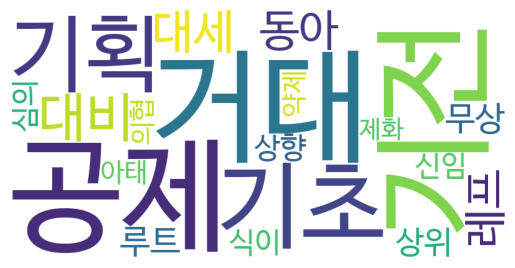

In [71]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud_an)
plt.axis('off')
plt.show()